<a href="https://colab.research.google.com/github/Strojove-uceni/23206-final-sos/blob/main/text_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Handwritten Text Recognition using CNN-RNN Hybrid with LSTM**

**Authors:**

*   Daniel Khol, AMSM
*   Matěj Trödler, AMSM

# Abstact:
Handwritten text recognition remains a challenging task in the field of pattern recognition and machine learning. The project presents a sophisticated approach to recognize handwritten text, leveraging a hybrid neural network architecture combining Convolutional Neural Networks (CNN) and Recurrent Neural Networks (RNN) with Long Short-Term Memory (LSTM) units. This method aims to effectively capture both the spatial features of handwriting through CNNs and the sequential nature of text via RNNs. We have found similar architecture in most of models that tried to solve this problem.  

*Keywords:*

Handwritten Text Recognition, Convolutional Neural Networks, Recurrent Neural Networks, Long Short-Term Memory, Pattern Recognition, Machine Learning.

# Methodology:

*Setup:*

The notebook begins by setting up the environment, which includes installing necessary libraries like Pillow for image handling, lightning for PyTorch Lightning functionalities, and Wandb for experiment tracking.

*Data Handling:*

The IAM Words dataset, a popular choice for handwriting recognition tasks, is downloaded and extracted.
The dataset is processed to create a list of image paths with corresponding text labels, along with the formation of a character vocabulary and determination of the longest word length.

*DataModule Implementation:*

The custom IAMWordsDataset class handles data loading and splitting into training and validation sets.
TextRecognitionDataModule utilizes PyTorch Lightning for efficient data handling, applying image transformations and data augmentation techniques to improve model robustness.


*Model Architecture:*

A multi-layered approach is adopted, where initial layers are CNN-based (with residual connections for deeper feature extraction) followed by LSTM layers for sequence modeling.
Activation functions ReLU and LeakyReLU are used, and dropout is incorporated for regularization.

*Training Process:*

The model is trained using the Adam optimizer, with the CTC loss function addressing the alignment problem in sequence prediction.
Training involves multiple epochs where the model learns to map the input images to the corresponding text sequences.
Validation and Logging:

Validation steps are defined for performance evaluation on unseen data.
Loss and accuracy metrics are logged using CSVLogger for monitoring the training progress.

*Decoding and Accuracy Calculation:*

Post-training, the outputs are decoded from numerical indices to text strings.
Accuracy assessments include character-level and word-level accuracy computations.

*Result Visualization:*

Training and validation losses are plotted, providing insights into the learning process and model convergence.
A selection of predictions versus actual labels is displayed to visually assess the model's performance.


# Conclusion:
This project demonstrates a comprehensive approach to handwriting recognition using a CNN-RNN hybrid model. The use of PyTorch Lightning streamlines the training and validation process, making the code more organized and scalable. Future enhancements could include experimenting with different network architectures, hyperparameter tuning, and extending the model to handle more diverse handwriting styles and languages.




First of all, install all neccesary packages

In [1]:
!pip install Pillow
!pip install lightning
!pip install opencv-python
!pip install torchvision
!pip install Wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.7 MB/s eta 0:00:00


In [2]:
import os
import torch
import torch.nn as nn
import lightning.pytorch as pl
from lightning.pytorch.loggers import CSVLogger, WandbLogger
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms import ToTensor, Resize, ColorJitter, RandomRotation, \
    RandomAdjustSharpness, RandomAutocontrast, AutoAugment, RandomAffine, RandomErasing

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from zipfile import ZipFile
from urllib.request import urlopen
from io import BytesIO
from PIL import Image
import tarfile


import wandb

#Download data
This function downloads data from a given path and extractc it into new folder *Datasets*. Data consists of folder *words* with many subfolders with images. Then it also contains text file *words.txt* with images file path and the annotated label.

In [3]:
def download_and_unzip(url, extract_to='Datasets', chunk_size=1024*1024):
    http_response = urlopen(url)

    data = b''
    iterations = http_response.length // chunk_size + 1
    for _ in tqdm(range(iterations)):
        data += http_response.read(chunk_size)

    zipfile = ZipFile(BytesIO(data))
    zipfile.extractall(path=extract_to)

The data is now extracted into a form suitable for our purposes. An array dataset is created, consisting of the path of the image and its label. A set vocabulary comprising all used characters is then constructed. This includes all capital letters, small letters, and punctuation marks such as ?!,.-, etc. The length of the longest word in the dataset is determined, which, as will be seen, is utilized in the DataModule. Images that are damaged are identified, and these are excluded from further processing.

In [4]:
dataset_path = os.path.join('Datasets', 'IAM_Words')
if not os.path.exists(dataset_path):
    download_and_unzip('https://git.io/J0fjL', extract_to='Datasets')

    file = tarfile.open(os.path.join(dataset_path, "words.tgz"))
    file.extractall(os.path.join(dataset_path, "words"))


dataset, vocab, max_len = [], set(), 0

# Preprocess the dataset by the specific IAM_Words dataset file structure
words = open(os.path.join(dataset_path, "words.txt"), "r").readlines()
for line in tqdm(words):
    if line.startswith("#"):
        continue

    line_split = line.split(" ")
    if line_split[1] == "err":
        continue

    folder1 = line_split[0][:3] # extract the folder name
    folder2 = "-".join(line_split[0].split("-")[:2]) # extract the sub-folder name
    file_name = line_split[0] + ".png" # extract the file name
    label = line_split[-1].rstrip('\n') # the label, last element of row, remove the \n at the end

    # the relative path to the image file
    rel_path = os.path.join(dataset_path, "words", folder1, folder2, file_name)
    try:
        # Attempt to open the image in case there can be a demaged one
        image = Image.open(rel_path).convert("RGB")
    except (Image.UnidentifiedImageError, OSError) as e:
        print(f"Error opening image: {rel_path}, {e}")
        continue

    # append path and the label to dataset
    dataset.append([rel_path, label])

    # append label to vocab
    vocab.update(list(label))

    # length of the longest word
    max_len = max(max_len, len(label))

  4%|▍         | 4777/115338 [00:01<00:36, 3052.60it/s]

Error opening image: Datasets/IAM_Words/words/a01/a01-117/a01-117-05-02.png, cannot identify image file 'Datasets/IAM_Words/words/a01/a01-117/a01-117-05-02.png'


 99%|█████████▉| 114142/115338 [00:38<00:00, 3443.39it/s]

Error opening image: Datasets/IAM_Words/words/r06/r06-022/r06-022-03-05.png, cannot identify image file 'Datasets/IAM_Words/words/r06/r06-022/r06-022-03-05.png'


100%|██████████| 115338/115338 [00:38<00:00, 2966.40it/s]


Working with a sorted vocabulary is preferred. In the upcoming script, within the Neural Network (NN), numbers will replace strings. Words will be converted into arrays in the following manner: each character will be transformed into numbers representing the position of that letter in the vocabulary. An example is provided:

In [5]:
vocab = "".join(sorted(vocab))
print(vocab)

!"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [6]:
example = ['peter', 'america', ',', 'you']

indices_array = np.array([vocab.index(l) for word in example for l in word if l in vocab])
print(indices_array)

[67 56 71 56 69 52 64 56 69 60 54 52  9 76 66 72]


#DataModule
A DataModule will be prepared for our neural network. Initially, a Dataset class is defined, returning an image and its label from the dataset array and splitting the data into training and validation sets.

In [7]:
class IAMWordsDataset(Dataset):
    def __init__(self, dataset, vocab, max_len, split="train", train_val_split=0.9):
        """
        IAMWordsDataset represents the dataset for the IAM Words dataset.

        Args:
        - dataset (list): A list of tuples, each containing the image path and corresponding label.
        - vocab (list): A list containing the vocabulary for the dataset.
        - max_len (int): The maximum length of a label sequence.
        - split (str): The split of the dataset, either "train" or "val".
        - train_val_split (float): The percentage split for training and validation sets.
        """
        self.dataset = dataset
        self.vocab = vocab
        self.max_len = max_len
        self.split = split
        self.train_val_split = train_val_split

        # Split the dataset into training or validation based on the specified split
        if self.split == "train":
            self.dataset = self.dataset[:int(len(self.dataset) * self.train_val_split)]
        elif self.split == "val":
            self.dataset = self.dataset[int(len(self.dataset) * self.train_val_split):]

    def __len__(self):
        # Returns the total number of samples in the dataset.
        return len(self.dataset)

    def __getitem__(self, idx):
        # Returns a tuple containing the image (as a PIL Image) and its corresponding label.
        image_path, label = self.dataset[idx]
        image = Image.open(image_path).convert("RGB")

        return image, label

Next, the construction of a DataModule is undertaken. Images are resized to a uniform size and converted into tensors. However, before this, in the training data loader, various augmentations are applied to enhance the accuracy of the network. Brightness is randomly adjusted within the range of [-0.5, 0.5]. Random rotation within a 30° range and adjustments to sharpness and contrast are also applied. Labels are converted into integer tensors, with each character represented by its index in the vocabulary. Padded labels are then created using the max_len to ensure consistent length for batch processing. Finally, the collated batch returns transformed images and padded labels.

In [8]:
class TextRecognitionDataModule(pl.LightningDataModule):
    def __init__(self, dataset, vocab, max_len, batch_size=64):
        super().__init__()
        # Initialize with dataset, vocabulary, maximum sequence length, and batch size
        self.batch_size = batch_size
        self.dataset = dataset
        self.vocab = vocab
        self.max_len = max_len

    def setup(self, stage=None):
        # Set up the training and validation datasets
        self.train_dataloader()
        self.val_dataloader()

    def train_dataloader(self):
        # Initialize and return the training DataLoader
        self.train_dataset = IAMWordsDataset(self.dataset, self.vocab, self.max_len, split="train")
        print("Train Dataloader called")
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True,
                          collate_fn=self.train_collate, num_workers=4, persistent_workers=True)

    def val_dataloader(self):
        # Initialize and return the validation DataLoader
        self.val_dataset = IAMWordsDataset(self.dataset, self.vocab, self.max_len, split="val")
        print("Validation Dataloader called")
        return DataLoader(self.val_dataset, batch_size=self.batch_size,
                          collate_fn=self.val_collate, num_workers=4, persistent_workers=True)

    # Apply transformers on images and labels during training
    def train_collate(self, batch):
        images, labels = zip(*batch)

        # Define a series of image transformations
        transform = transforms.Compose([
            Resize((128, 32)),  # Resize on the same shape
            ColorJitter(brightness=0.5),  # Randomly adjust brightness
            RandomRotation(degrees=10),  # Randomly rotate the image
            RandomAffine(degrees=0, shear=10),
            RandomAffine(degrees=0, translate=(0.1, 0.1)),
            RandomAffine(degrees=0, scale=(0.8, 1.2)),
            RandomAdjustSharpness(sharpness_factor=2),  # Randomly adjust sharpness
            RandomAutocontrast(),  # Randomly adjust contrast
            #AutoAugment(),  # Apply other transformations
            ToTensor()])  # Convert into a tensor

        # Apply all defined transformers to each image in the batch
        images = [transform(image) for image in images]

        # Convert labels to integer tensors according to our vocab set
        converted_labels = [torch.tensor([self.vocab.index(l) for l in label if l in self.vocab], dtype=torch.long)
                            for label in labels]

        # Pad the labels to the same length for batch processing
        padded_labels = torch.nn.utils.rnn.pad_sequence(converted_labels,
                                                        batch_first=True,
                                                        padding_value=0)
        return torch.stack(images), padded_labels

    # Apply transformers on images and labels during validation
    def val_collate(self, batch):
        images, labels = zip(*batch)

        # Define a series of image transformations
        transform = transforms.Compose([
            Resize((128, 32)),  # Resize on the same shape
            ToTensor()])  # Convert into a tensor

        # Apply all defined transformers to each image in the batch
        images = [transform(image) for image in images]

        # Convert labels to integer tensors according to our vocab set
        converted_labels = [torch.tensor([self.vocab.index(l) for l in label if l in self.vocab], dtype=torch.long)
                            for label in labels]

        # Pad the labels to the same length for batch processing
        padded_labels = torch.nn.utils.rnn.pad_sequence(converted_labels,
                                                        batch_first=True,
                                                        padding_value=0)
        return torch.stack(images), padded_labels

#Model
The model is now defined. Initially, a choice of activation layer is added, with options such as ReLU or LeakyReLU.

In [9]:
def activation_layer(activation: str="relu", alpha: float=0.1, inplace: bool=True):
    """ Activation layer wrapper for LeakyReLU and ReLU activation functions

    Args:
        activation: str, activation function name (default: 'relu')
        alpha: float (LeakyReLU activation function parameter)

    Returns:
        torch.Tensor: activation layer
    """
    if activation == "relu":
        return nn.ReLU(inplace=inplace)

    elif activation == "leaky_relu":
        return nn.LeakyReLU(negative_slope=alpha, inplace=inplace)

The neural network will consist of many similar blocks, which can be included in a separate class. An essential process, the convolution block, is utilized. A 2D convolution layer with varying input and output channel numbers is applied, followed by batch normalization. Using this block, a residual block with an optional shortcut connection and dropout can be constructed.

In [10]:
class ConvBlock(nn.Module):
    # Convolutional block with batch normalization
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int, padding: int):
        """
        Initializes the ConvBlock.

        Parameters:
        - in_channels (int): Number of input channels.
        - out_channels (int): Number of output channels.
        - kernel_size (int): Size of the convolutional kernel.
        - stride (int): Stride for the convolutional operation.
        - padding (int): Padding for the convolutional operation.
        """
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x: torch.Tensor):
        """
        Forward pass through the ConvBlock.

        Parameters:
        - x (torch.Tensor): Input tensor.

        Returns:
        - torch.Tensor: Output tensor after applying convolution and batch normalization.
        """
        return self.bn(self.conv(x))


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, skip_conv=True, stride=1, dropout=0.2, activation="leaky_relu"):
        """
        Initializes the ResidualBlock.

        Parameters:
        - in_channels (int): Number of input channels.
        - out_channels (int): Number of output channels.
        - skip_conv (bool): Flag indicating whether to use a skip connection.
        - stride (int): Stride for the convolutional operation.
        - dropout (float): Dropout probability.
        - activation (str): Activation function to use.
        """
        super(ResidualBlock, self).__init__()

        # Convolutional block 1
        self.convb1 = ConvBlock(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.act1 = activation_layer(activation)

        # Convolutional block 2
        self.convb2 = ConvBlock(out_channels, out_channels, kernel_size=3, stride=1, padding=1)

        # Dropout layer
        self.dropout = nn.Dropout(p=dropout)

        # Shortcut connection
        self.shortcut = None
        if skip_conv:
            if stride != 1 or in_channels != out_channels:
                self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)

        # Activation after the residual connection
        self.act2 = activation_layer(activation)

    def forward(self, x):
        """
        Forward pass through the ResidualBlock.

        Parameters:
        - x (torch.Tensor): Input tensor.

        Returns:
        - torch.Tensor: Output tensor after applying residual connections, activations, and dropout.
        """
        skip = x

        out = self.act1(self.convb1(x))
        out = self.convb2(out)

        # Adding the shortcut connection
        if self.shortcut is not None:
            out += self.shortcut(skip)

        out = self.act2(out)
        out = self.dropout(out)

        return out

#CNN model

This class encapsulates the entire neural network model aimed at recognizing handwritten text. The initialization method init of the class sets up the neural network architecture.nThe forward method defines the forward pass of the model. It takes input images, processes them through the residual blocks and the LSTM layer, and then applies a linear transformation followed by a log softmax function. Then trading and validation happends. Finally, the configure_optimizers method sets up the optimizer for the model training, using the Adam optimizer with a specific learning rate.

In [11]:
class CNNmodel(pl.LightningModule):
    def __init__(self, pad_val, num_chars: int, activation: str="leaky_relu", dropout: float=0.2):
        """
        Initializes the CNNmodel.

        Parameters:
        - pad_val (int): Padding value used for CTC loss.
        - num_chars (int): Number of characters in the output (excluding blank).
        - activation (str): Activation function to use in ResidualBlocks.
        - dropout (float): Dropout probability.
        """
        super(CNNmodel, self).__init__()

        self.pad_val = pad_val

        # Residual Blocks
        self.rb1 = ResidualBlock(3, 16, skip_conv=True, stride=1, activation=activation, dropout=dropout)
        self.rb2 = ResidualBlock(16, 16, skip_conv=True, stride=2, activation=activation, dropout=dropout)
        self.rb3 = ResidualBlock(16, 16, skip_conv=False, stride=1, activation=activation, dropout=dropout)
        self.rb4 = ResidualBlock(16, 32, skip_conv=True, stride=2, activation=activation, dropout=dropout)
        self.rb5 = ResidualBlock(32, 32, skip_conv=False, stride=1, activation=activation, dropout=dropout)
        self.rb6 = ResidualBlock(32, 64, skip_conv=True, stride=2, activation=activation, dropout=dropout)
        self.rb7 = ResidualBlock(64, 64, skip_conv=True, stride=1, activation=activation, dropout=dropout)
        self.rb8 = ResidualBlock(64, 64, skip_conv=False, stride=1, activation=activation, dropout=dropout)
        self.rb9 = ResidualBlock(64, 64, skip_conv=False, stride=1, activation=activation, dropout=dropout)

        # LSTM layer
        self.lstm = nn.LSTM(64, 128, bidirectional=True, num_layers=1, batch_first=True)
        self.lstm_dropout = nn.Dropout(p=dropout)

        # Output linear layer
        self.output = nn.Linear(256, num_chars + 1)

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the CNNmodel.

        Parameters:
        - images (torch.Tensor): Input images.

        Returns:
        - torch.Tensor: Log softmax probabilities for each character.
        """
        images_float = images / 255.0

        # Residual Blocks forward pass
        x = self.rb1(images_float)
        x = self.rb2(x)
        x = self.rb3(x)
        x = self.rb4(x)
        x = self.rb5(x)
        x = self.rb6(x)
        x = self.rb7(x)
        x = self.rb8(x)
        x = self.rb9(x)

        x = x.reshape(x.size(0), -1, x.size(1))

        # LSTM layer forward pass
        x, _ = self.lstm(x)
        x = self.lstm_dropout(x)

        # Output layer forward pass with log softmax
        x = self.output(x)
        x = F.log_softmax(x, 2)

        return x

    def training_step(self, batch, batch_idx):
        """
        Training step for the Lightning module.

        Parameters:
        - batch: Training batch.
        - batch_idx: Index of the batch.

        Returns:
        - torch.Tensor: Training loss.
        """
        images, targets = batch

        # Forward pass
        # Returns log softmax, i.e., tensor with log probabilities for each class
        # It is of shape (batch_size, sequence_length, num_classes)
        outputs = self(images)

        # Compute unpadded target lengths
        target_lengths = torch.sum(targets != self.pad_val, dim=1)
        # Compute unpadded targets and merge them into 1D tensor
        targets_unpadded = targets[targets != self.pad_val].view(-1)
        # For CTC loss, it is necessary to permute the outputs to shape (sequence_length, batch_size, num_classes)
        outputs = outputs.permute(1, 0, 2)
        # Compute the outputs length, i.e., tensor of batch size
        outputs_lengths = torch.full(size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long)
        # Compute CTC loss
        loss = F.ctc_loss(outputs, targets_unpadded, outputs_lengths, target_lengths, blank=self.pad_val)

        # Logging and return loss
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        """
        Validation step for the Lightning module.

        Parameters:
        - batch: Validation batch.
        - batch_idx: Index of the batch.

        Returns:
        - torch.Tensor: Validation loss.
        """
        images, targets = batch

        # Forward pass
        # Returns log softmax, i.e., tensor with log probabilities for each class
        # It is of shape (batch_size, sequence_length, num_classes)
        outputs = self(images)

        # Compute unpadded target lengths
        target_lengths = torch.sum(targets != self.pad_val, dim=1)
        # Compute unpadded targets and merge them into 1D tensor
        targets_unpadded = targets[targets != self.pad_val].view(-1)
        # For CTC loss, it is necessary to permute the outputs to shape (sequence_length, batch_size, num_classes)
        outputs = outputs.permute(1, 0, 2)
        # Compute the outputs length, i.e., tensor of batch size
        outputs_lengths = torch.full(size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long)
        # Compute CTC loss
        loss = F.ctc_loss(outputs, targets_unpadded, outputs_lengths, target_lengths, blank=self.pad_val)

        # Logging and return loss
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        """
        Configure optimizer for the Lightning module.

        Returns:
        - torch.optim.Optimizer: Optimizer for the model.
        """
        optimizer = torch.optim.Adam(self.parameters(), lr=5e-6)
        return optimizer

In [12]:
print(torch.cuda.is_available())

True


#Train model

The data module is set up for training. For the training environment, the code checks for available GPUs, sets up a logger for progress tracking, and configures a checkpointing system to save the best model based on validation loss. The model is trained using PyTorch Lightning's Trainer, which manages the training process with the provided configurations.

In [13]:
# Initialize the model and data module
data_module = TextRecognitionDataModule(dataset, vocab, max_len)
model = CNNmodel(pad_val = 0, num_chars=len(vocab))
'''len(data_module.train_dataset.vocab)'''

# Prepare the data module for training
data_module.setup('train')

#------------------------------------------------------------------------------
# Test DataLoader

print("Testing DataLoader...")
#------------------------------------------------------------------------------

# Get the number of available GPUs, else use CPU
ngpus = torch.cuda.device_count() if torch.cuda.is_available() else 1

logger = CSVLogger("logs", name="TextRecognition")

# Train and Validate the model
checkpoint_callback = pl.callbacks.ModelCheckpoint(
        monitor='val_loss',  # Metric to monitor
        dirpath='/content',  # Path where to save models
        filename='text_recognition',  # Filename for the checkpoint
        save_top_k=1,  # Save the top 1 models
        mode='min',  # Mode 'min' for loss and 'max' for accuracy
        )

trainer = pl.Trainer(logger=CSVLogger("logs", name="TextRecognition"), devices=ngpus, accelerator="gpu" if ngpus > 0 else None, max_epochs=1,
                     callbacks=[checkpoint_callback])
trainer.fit(model, data_module)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train Dataloader called
Validation Dataloader called
Testing DataLoader...


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /content exists and is not empty.


Train Dataloader called
Validation Dataloader called


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name         | Type          | Params
------------------------------------------------
0  | rb1          | ResidualBlock | 2.9 K 
1  | rb2          | ResidualBlock | 5.0 K 
2  | rb3          | ResidualBlock | 4.7 K 
3  | rb4          | ResidualBlock | 14.6 K
4  | rb5          | ResidualBlock | 18.6 K
5  | rb6          | ResidualBlock | 57.8 K
6  | rb7          | ResidualBlock | 74.1 K
7  | rb8          | ResidualBlock | 74.1 K
8  | rb9          | ResidualBlock | 74.1 K
9  | lstm         | LSTM          | 198 K 
10 | lstm_dropout | Dropout       | 0     
11 | output       | Linear        | 20.3 K
------------------------------------------------
544 K     Trainable params
0         Non-trainable params
544 K     Total params
2.179     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
   | Name         | Type   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Validation Dataloader called
Train Dataloader called


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In this code, a function is defined to plot training and validation losses, which are read from a log file of a machine learning model.

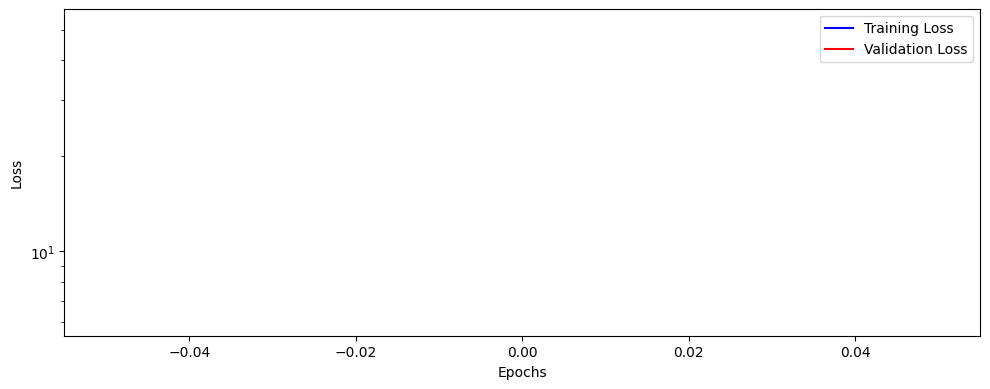

In [14]:
log_dir = 'version_0'

def plot_csv_losses(df_cleaned):
    fig = plt.figure(figsize=(10, 4))
    plt.plot(df_cleaned['epoch'], df_cleaned['train_loss_epoch'], label='Training Loss', c='b')
    plt.plot(df_cleaned['epoch'], df_cleaned['val_loss_epoch'], label='Validation Loss', c='r')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

log_file = f'/content/logs/TextRecognition/{log_dir}/metrics.csv'
df = pd.read_csv(log_file)
df_grouped = df.groupby('epoch').first().reset_index()
plot_csv_losses(df_grouped)

Model outputs are translated into sequences of labels by the decode function, which filters out repetitions and blank labels. Numerical labels are converted into text using a provided vocabulary by the label_to_string function. Accuracy is calculated at both the overall string level and individual character level.

In [20]:
def decode(output, blank_label=0):
    max_indices = torch.argmax(output, dim=-1)
    #print('max_indices:', max_indices)
    decoded_sequence = []
    for label in max_indices.cpu().numpy():
        if label != blank_label and (not decoded_sequence or label != decoded_sequence[-1]):
            decoded_sequence.append(label)
    #print(decoded_sequence)

    return decoded_sequence

def label_to_string(label, vocab):
    strings = "".join([vocab[k] for k in label if k < len(vocab)])
    return strings

def calculate_accuracy(true_strings, pred_strings):
    correct_results = sum([1 for true, pred in zip(true_strings, pred_strings) if true == pred])
    total_results = len(true_strings)
    return correct_results, total_results

def calculate_digit_accuracy(true_strings, pred_strings, max_len):
    digit_correct = 0
    digit_total = 0

    for true, pred in zip(true_strings, pred_strings):
        for true_digit, pred_digit in zip(true, pred):
            digit_total += 1
            if true_digit == pred_digit:
                digit_correct += 1

    return digit_correct, digit_total

def correct(model, loader, vocab, blank_label=0):
    !wget https://github.com/Strojove-uceni/23206-final-sos/blob/main/check_point.ckpt
    checkpoint_path = '/content/check_point.ckpt'
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    device = next(model.parameters()).device

    #print('max_len:', data_module.max_len)

    correct_results = 0
    total_results = 0
    true_strings = []
    pred_strings = []
    digits_correct, digits_total = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            y_hat = model(x)

            decoded_preds = [decode(word) for word in y_hat]

            y_dec = []

            for label in y:
                decoded_sequence = []
                for i in label:
                    if i != blank_label and (not decoded_sequence or i != decoded_sequence[-1]):
                        decoded_sequence.append(i)
                y_dec.append(decoded_sequence)

            pred_strings.extend([label_to_string(pred, vocab) for pred in decoded_preds])
            true_strings.extend([label_to_string(target, vocab) for target in y_dec])

            cor_res, tot_res = calculate_accuracy(true_strings, pred_strings)
            correct_results += cor_res
            total_results += tot_res

            digit_correct, digit_total = calculate_digit_accuracy(true_strings, pred_strings, data_module.max_len)
            digits_correct.append(digit_correct)
            digits_total.append(digit_total)


    accuracy = correct_results / total_results if total_results > 0 else 0.0

    digit_correct = sum(digits_correct)
    digit_total = sum(digits_total)
    digit_accuracy = digit_correct / digit_total

    return accuracy, digit_accuracy, true_strings, pred_strings

train_accuracy, train_digit_accuracy, train_true_strings, train_pred_strings = correct(model, data_module.train_dataloader(), vocab)
print(f'Training set accuracy: {train_accuracy} correctly classified, an accuracy of {train_accuracy:.2f}%!')
print(f'Training set average CER: {train_digit_accuracy:.4f}')

val_accuracy, val_digit_accuracy, val_true_strings, val_pred_strings = correct(model, data_module.val_dataloader(), vocab)
print(f'Validation set accuracy: {val_accuracy} correctly classified, an accuracy of {val_accuracy:.2f}%!')
print(f'Validation set average CER: {val_digit_accuracy:.4f}')

for i in range(min(10, len(train_true_strings))):
    print(f'True: {train_true_strings[i]}, Predicted: {train_pred_strings[i]}')

Train Dataloader called
--2023-12-15 22:21:44--  https://github.com/Strojove-uceni/23206-final-sos/blob/main/check_point.ckpt
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4783 (4.7K) [text/plain]
Saving to: ‘check_point.ckpt’

check_point.ckpt    100%[===================>]   4.67K  --.-KB/s    in 0s      

2023-12-15 22:21:44 (36.2 MB/s) - ‘check_point.ckpt’ saved [4783/4783]



UnpicklingError: ignored

In [18]:
checkpoint_path = '/content/text_recognition.ckpt'
checkpoint = torch.load(checkpoint_path)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(checkpoint['state_dict'])
model.to(device)   # Load the model to the correct device
model.eval()

CNNmodel(
  (rb1): ResidualBlock(
    (convb1): ConvBlock(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): LeakyReLU(negative_slope=0.1, inplace=True)
    (convb2): ConvBlock(
      (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (dropout): Dropout(p=0.2, inplace=False)
    (shortcut): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
    (act2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (rb2): ResidualBlock(
    (convb1): ConvBlock(
      (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): LeakyReLU(negative_slope=0.1, inplace=True)
    (convb2): ConvBlock(
      (conv): Conv2d(16, 16

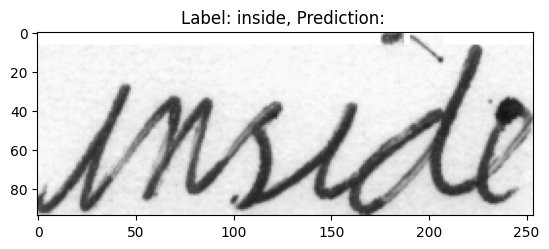

In [19]:
import random

val_dataset = IAMWordsDataset(dataset, vocab, max_len, split="val")
image, labelx = val_dataset[50]

with torch.no_grad():
    transform = transforms.Compose([
            Resize((128, 32)),
            ColorJitter(brightness=0.5),
            RandomRotation(degrees=10),
            RandomAffine(degrees=0, shear=10),
            RandomAffine(degrees=0, translate=(0.1, 0.1)),
            RandomAffine(degrees=0, scale=(0.8, 1.2)),
            RandomAdjustSharpness(sharpness_factor=2),
            RandomAutocontrast(),
            RandomErasing(),
            AutoAugment(),
            ToTensor()])

    image_trans = transform(image).to(device)
    image_trans = image_trans.unsqueeze(0)  # Add a batch dimension
    output = model(image_trans)

    max_indices = torch.argmax(output, dim=-1)
    #print('max_indices:', max_indices)
    decoded = []
    for label in max_indices[0]:
        if label != 0 and (not decoded or label != decoded[-1]):
            decoded.append(label)

    prediction = label_to_string(decoded, vocab)


plt.imshow(image)
plt.title(f"Label: {labelx}, Prediction: {prediction}")
plt.show()